# Imports section

In [216]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Description of the dataset can be found here :  
https://www.synapse.org/#!Synapse:syn2811262/wiki/78375 

Data is imported from this Github
https://github.com/dream-olfaction/olfaction-prediction

## Labels : Odor classes

Below are the labels we are trying to predict :  
*   CID : unique identifier, only here to link labels to values (molecule chemical description)
*   Odor to subject : these columns can be removed as they are not part of our study
*  From "Intensity" to "Chemical" : these are the classes we are trying to predict

In [217]:
url_train = 'https://raw.githubusercontent.com/dream-olfaction/olfaction-prediction/master/data/TrainSet.txt'
url_test = 'https://raw.githubusercontent.com/dream-olfaction/olfaction-prediction/master/data/TestSet.txt'

In [218]:
train_df = pd.read_csv(url_train, sep='	')
train_df

Compound Identifier                    Odor  ... FLOWER CHEMICAL
0                      126  4-Hydroxybenzaldehyde   ...    0.0      0.0
1                      126  4-Hydroxybenzaldehyde   ...    0.0      0.0
2                      126  4-Hydroxybenzaldehyde   ...    0.0      5.0
3                      126  4-Hydroxybenzaldehyde   ...    0.0      7.0
4                      126  4-Hydroxybenzaldehyde   ...    0.0      0.0
...                    ...                     ...  ...    ...      ...
35079              6999977  Butyl (S)-(-)-lactate   ...    0.0      0.0
35080              6999977  Butyl (S)-(-)-lactate   ...    0.0      0.0
35081              6999977  Butyl (S)-(-)-lactate   ...    0.0     27.0
35082              6999977  Butyl (S)-(-)-lactate   ...    0.0      3.0
35083              6999977  Butyl (S)-(-)-lactate   ...    0.0     80.0

[35084 rows x 27 columns]

In [219]:
test_df = pd.read_csv(url_test, sep='	')
test_df

Compound Identifier  Odor  Replicate  ... GRASS FLOWER  CHEMICAL
0                     180   NaN          0  ...   0.0    0.0       0.0
1                     180   NaN          0  ...   0.0    0.0       0.0
2                     180   NaN          0  ...   0.0   33.0      23.0
3                     180   NaN          0  ...   0.0   97.0       0.0
4                     180   NaN          0  ...   0.0    0.0       0.0
...                   ...   ...        ...  ...   ...    ...       ...
3376             10857465   NaN          0  ...   0.0   57.0       0.0
3377             10857465   NaN          0  ...   1.0    1.0       1.0
3378             10857465   NaN          0  ...   0.0    0.0       0.0
3379             10857465   NaN          0  ...   0.0    0.0      19.0
3380             10857465   NaN          0  ...   0.0   10.0       0.0

[3381 rows x 27 columns]

## Values : Molecule Descriptors

We import the molecule descriptors that will help train the model to predict the classes imported in the previous section.  

This file is created thanks to :  EPI Suite ( https://www.epa.gov/tsca-screening-tools/epi-suitetm-estimation-program-interface )  

Check the commit for more information : https://github.com/dream-olfaction/olfaction-prediction/commit/b3af32714bf3dab1faab860bae01bbf30ba65578 

In [220]:
molecule_descriptors = 'https://raw.githubusercontent.com/dream-olfaction/olfaction-prediction/master/data/DREAM_episuite_descriptors.txt'
molecule_descriptors_df = pd.read_csv(molecule_descriptors, sep='\t')
molecule_descriptors_df

CID  ... AEROWIN Octanol/air phi
0         126  ...            2.060000e-02
1         176  ...            4.010000e-07
2         177  ...            3.290000e-09
3         180  ...            4.010000e-09
4         196  ...            1.090000e-01
..        ...  ...                     ...
471   6114390  ...            8.630000e-02
472   6429333  ...            4.490000e-05
473   6999977  ...            1.580000e-06
474  10857465  ...            5.620000e-05
475  16220109  ...            4.970000e-06

[476 rows x 64 columns]

# Raw data cleanup

## Odor Classes

### Missing labels class distribution

We define two functions to evaluate the percentage of NaN values in the dataframes and plot them as horizontal bar plots :

In [221]:
def percentage_missing_values(df):

  percent_missing = df.isnull().sum() * 100 / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                  'percent_missing': percent_missing})

  return missing_value_df

def plot_percentage_of_missing_values(df):
  plt.figure(figsize=(5,int(len(df.columns)/5)))
  ax = sns.barplot(x="percent_missing", y="column_name", data=percentage_missing_values(df), color='blue')
  plt.title('Percentage of missing classes')
  plt.show()

From the graph below, we can see that the training data has almost 100% values missing from the column "Replicate", and the same proportion of missing values in the Odor descriptor classes (25% each), which could suggest that the missing values are all located on the same lines (all NaN values are part of a single row, on 25% of all rows).

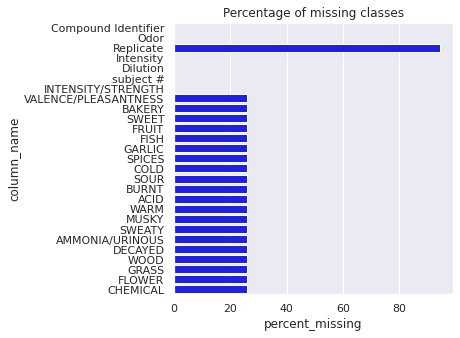

In [222]:
plot_percentage_of_missing_values(train_df)

On the test value, we do not miss any "Replicate" values but rather all "Odor" values. The Odor descriptors have all the same proportion of missing values : 10%. Again, we can infer than some rows have NaNs on all columns of the odor space.

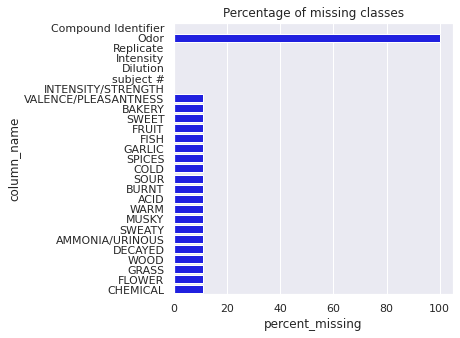

In [223]:
plot_percentage_of_missing_values(test_df)

From the above conclusions, we have to drop Odor descriptor lines with missing information before feeding them to any machine learning algorithm as NaNs can yield unprevisible results.  
We cannot simply delete these values as some samples risk being represented in the training set and not in the test set, and conversely, some samples risk being in the test set and not in the training set. We will study the "subject #" to see if we can infer a correlation between deleted values and test subject id.

We also have to solve the "Odor" and "Replicate" column issues : delete both, or copy values from training to test, and test to training.  

### Missing odor descriptors : sample removal

The line below selects all subject ids from train and test dataframes where the "FRUIT" column contains NaN values. It then substracts the test set from the training set and the result is an empty set.  

This means that all the subject ids from test set that have NaN values in their respective rows are included into the training set, and thus, are the same.  

From this check, we are sure that, by deleting all NaN values in the Odor space columns, both in the training and test sets, we will not have subjects whose data will either be represented into one set or the other : it will effectively be erased from both sets.

In [224]:
set(test_df[test_df.FRUIT.isnull()]['subject #']) - set(train_df[train_df.FRUIT.isnull()]['subject #'])

set()

We process with data deletion :

In [225]:
train_df.dropna(inplace=True, subset=['FRUIT'])
test_df.dropna(inplace=True, subset=['FRUIT'])

We plot again the NaN counts as bar plots to check whether we still have missing values :

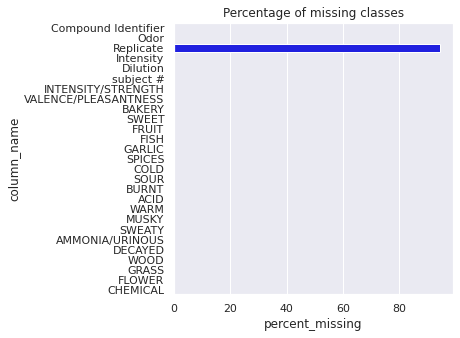

In [226]:
plot_percentage_of_missing_values(train_df)

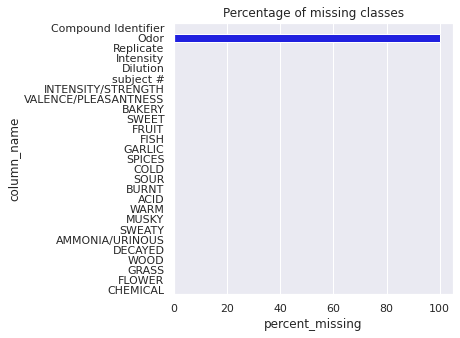

In [227]:
plot_percentage_of_missing_values(test_df)

The odor descriptors are all set and the subjects which are not part of the experiment are removed.  
We are now interested in the "Odor" and "Replicate" columns : what are they and why are they empty ?

### "Odor" and "Replicate" columns : what are they and should we remove them ?

From the label description provided by the DREAM challenge( https://www.synapse.org/#!Synapse:syn2811262/wiki/78375 ), we can say that :

*   "Odor" (fully provided in train dataset, absent from test dataset) is totally useless for training. It contains the human-readable form of the CID (which is a unique id per molecule). A chemist might get an intuition about the molecule composition by looking at the odor columns, but both CID and ODOR are labels which should be stripped before training. Odor also has the particularity of having synonyms, which makes it a worse identifier than CID (a true unique identifier). I suggest to create a new dataframe containing only CID and Odor to link them in the future, and remove the Odor column from both the train and test datasets.  

*   Replicate indicates whether the molecules have been tested a second time in a laboratory. This could be useful to give a certain weight to certain samples (samples tested a second time that have the same odor descriptors as the first time should get extra weight), but at first we will also remove this column from train and test datasets.

In [228]:
train_df.drop('Odor', inplace=True, axis=1)
test_df.drop('Odor', inplace=True, axis=1)

train_df.drop('Replicate', inplace=True, axis=1)
test_df.drop('Replicate', inplace=True, axis=1)

After dropping the "Odor" and "Replicate" columns, we check the final distribution of NaN values for complete emptiness :

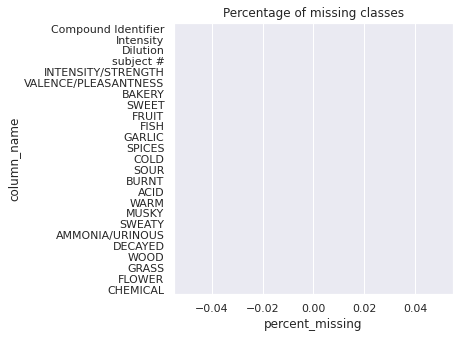

In [229]:
plot_percentage_of_missing_values(train_df)

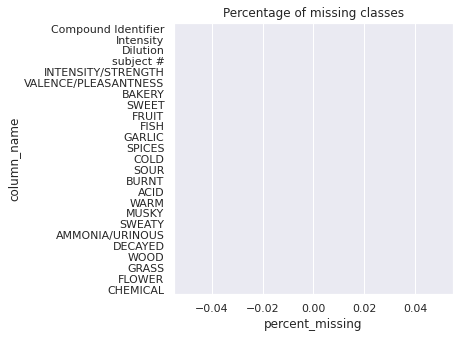

In [230]:
plot_percentage_of_missing_values(test_df)

### Type check

To use the datasets for training, we will need to have numerical values.

In [231]:
train_df.Dilution.unique()

array(['1/1,000 ', '1/10', '1/100,000 ', '1/10,000,000 '], dtype=object)

In [232]:
train_df.Intensity.unique()

array(['low ', 'high '], dtype=object)

We can see from above sets that the "Dilution" and "Intensity" columns contain non-numerical values.We will convert Intensity values from "low" and "high" to 1 and 2, and the "Dilution" values from strings representing sparse fractions to integers ranging from 1 to 4.

In [233]:
#apply to test dataframe
test_df['Intensity'] = test_df.apply(lambda row: 1 if (row['Intensity'] == 'low') else 2, axis=1)
test_df['Dilution'] = test_df.apply(lambda row: row['Dilution'].replace('\'', ''), axis=1)
test_df['Dilution'] = test_df.apply(lambda row: row['Dilution'].strip(), axis=1)

test_df['Dilution'] = test_df.apply(lambda row: ['1/1,000', '1/10', '1/100,000', '1/10,000,000'].index(row['Dilution'])+1, axis=1)

#apply to train dataframe and show result
train_df['Intensity'] = train_df.apply(lambda row: 1 if (row['Intensity'] == 'low') else 2, axis=1)
train_df['Dilution'] = train_df.apply(lambda row: row['Dilution'].strip(), axis=1)
train_df['Dilution'] = train_df.apply(lambda row: ['1/1,000', '1/10', '1/100,000', '1/10,000,000'].index(row['Dilution'])+1, axis=1)
train_df

Compound Identifier  Intensity  Dilution  ...  GRASS  FLOWER  CHEMICAL
0                      126          2         1  ...    0.0     0.0       0.0
1                      126          2         2  ...    0.0     0.0       0.0
2                      126          2         1  ...    0.0     0.0       5.0
3                      126          2         2  ...    0.0     0.0       7.0
4                      126          2         1  ...    0.0     0.0       0.0
...                    ...        ...       ...  ...    ...     ...       ...
35079              6999977          2         1  ...    0.0     0.0       0.0
35080              6999977          2         3  ...    0.0     0.0       0.0
35081              6999977          2         1  ...    0.0     0.0      27.0
35082              6999977          2         3  ...    0.0     0.0       3.0
35083              6999977          2         1  ...    0.0     0.0      80.0

[25980 rows x 25 columns]

We can say that the datasets are clean, we can now analyse the class distributions (see Dataset Analysis > Class distribution in labels)

## Molecule Descriptors

### Missing descriptors distributions

In [234]:
len(molecule_descriptors_df)

476

In this case, we see that a few columns are lacking most of their values :

*   2 columns have more than 80% missing values
*   2 columns have 60% missing values
*   2 columns have respectively 30% and 50% missing values

If we removed each row with missing values, we would risk losing nearly 90% of the descriptors. This dataset is made of one row per molecule (CID is used as a foreign key), any line removed in this dataframe equals to one line removed in the training and test datasets. Therefore, we cannot afford to remove even one single line.  

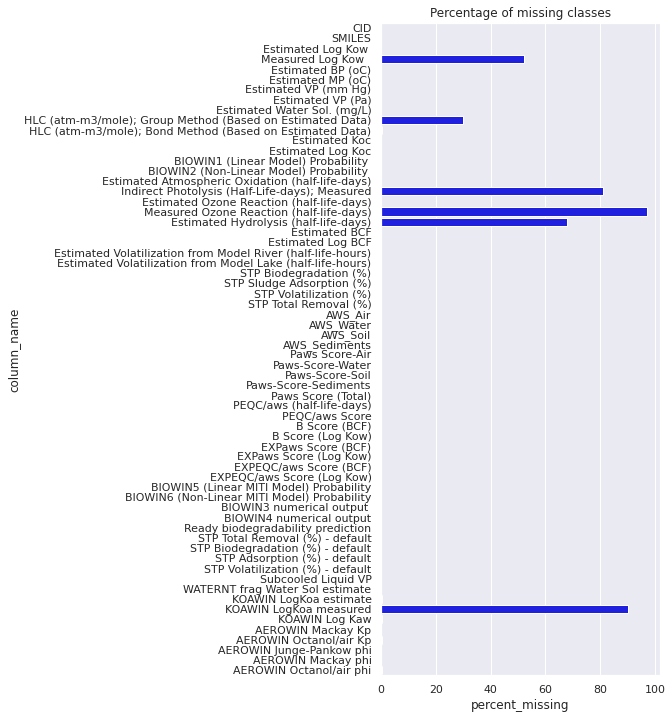

In [235]:
plot_percentage_of_missing_values(molecule_descriptors_df)

To mitigate this issue, we simply remove the corrupted columns.

In [236]:
molecule_descriptors_df.drop([
  'KOAWIN LogKoa measured',
  'Measured Ozone Reaction (half-life-days)',
  'Estimated Hydrolysis (half-life-days)',
  'Indirect Photolysis (Half-Life-days); Measured',
  'HLC (atm-m3/mole); Group Method (Based on Estimated Data)',
  'Measured Log Kow  '      
], axis=1, inplace=True)

We run the graph again and discover that some values are missing in very few rows (0.2%). We still cannot afford to loose any samples so we must remove these columns as well

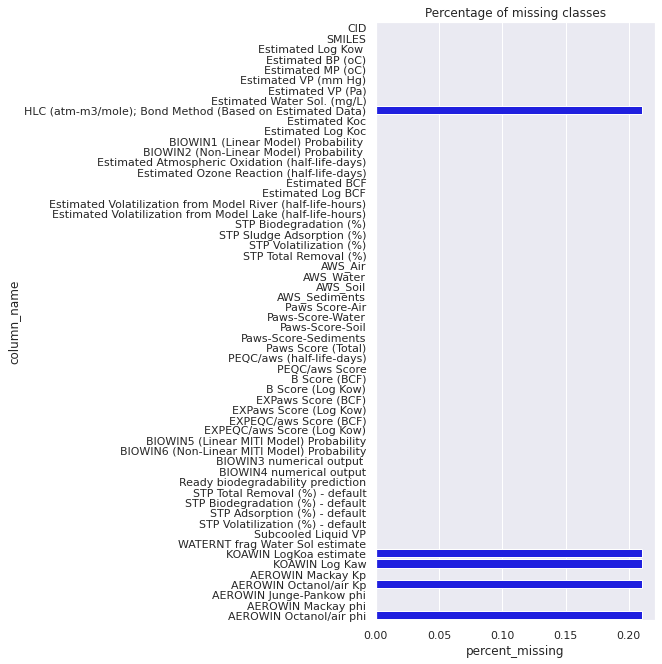

In [237]:
plot_percentage_of_missing_values(molecule_descriptors_df)

In [238]:
molecule_descriptors_df.drop([
'HLC (atm-m3/mole); Bond Method (Based on Estimated Data)',
'KOAWIN LogKoa estimate',
'KOAWIN Log Kaw',
'AEROWIN Octanol/air Kp',
'AEROWIN Octanol/air phi'
], axis=1, inplace=True)

This time, all the missing values have been eliminated through the deletion of columns. We have lost many attributes during phase 2 (because most values where defined on all samples), and we might change this step if the prediction results are not good enough.

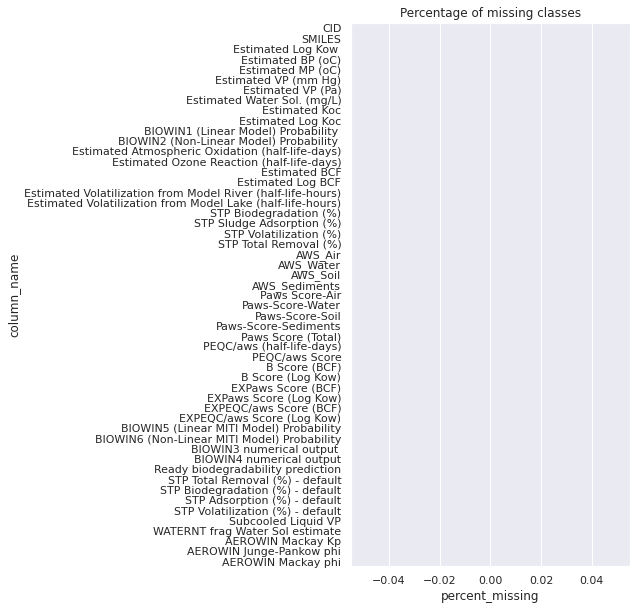

In [239]:
plot_percentage_of_missing_values(molecule_descriptors_df)

### Type check

Most columns contain numerical types, we convert a single column containing "Yes"/"No" values to 1 and 0 values :

In [240]:
molecule_descriptors_df['Ready biodegradability prediction'].unique()

array(['YES ', 'NO '], dtype=object)

In [241]:
molecule_descriptors_df['Ready biodegradability prediction'] = molecule_descriptors_df.apply(lambda row: 1 if (row['Ready biodegradability prediction'] == 'YES') else 0, axis=1)

We also need to drop the "SMILES" column which gives the chemical representation in a string form and is un-usable in randomForest and KNN :

In [249]:
molecule_descriptors_df.SMILES.unique()[:5]

array(['OC1=CC=C(C=O)C=C1 ', 'C(C)(=O)O ', 'C(C)=O ', 'CC(=O)C ',
       'C(CCCCC(=O)O)(=O)O '], dtype=object)

Before dropping, we keep a copy in a dataframe to use it in GNN :

In [250]:
molecule_smiles_df = molecule_descriptors_df[['CID', 'SMILES']]

In [251]:
molecule_descriptors_df.SMILES.unique()[:5]

array(['OC1=CC=C(C=O)C=C1 ', 'C(C)(=O)O ', 'C(C)=O ', 'CC(=O)C ',
       'C(CCCCC(=O)O)(=O)O '], dtype=object)

In [252]:
molecule_descriptors_df.drop('SMILES', axis=1, inplace=True)

# Dataset analysis

## Class distribution in labels

Below we display the heatmap of the pivot matrix between molecules and test subjects. Each white square is a test that wasn't made. Each black square is a test made by a subject on a molecule and was added to the dataset.

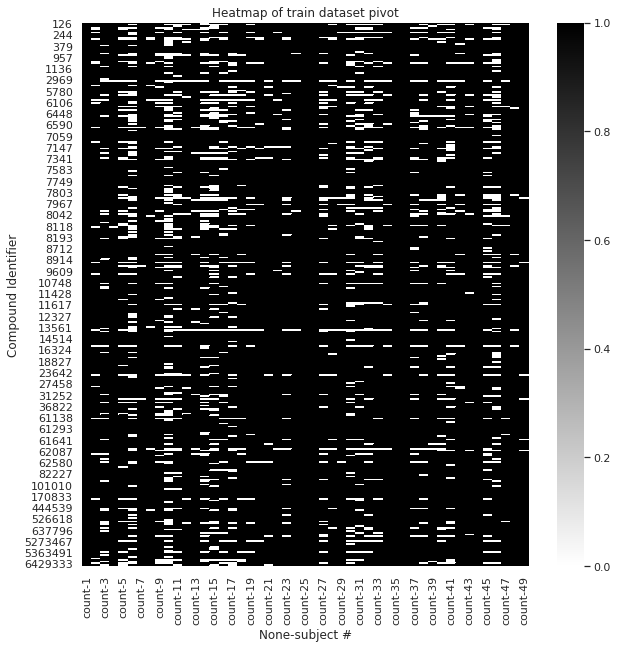

In [253]:
#convert molecule per test subject to pivot matrix
temp_df = train_df[['Compound Identifier', 'subject #']].drop_duplicates()
temp_df['count'] = 1
temp_df = temp_df.pivot(index=['Compound Identifier'], columns=['subject #'], values=['count'])
temp_df = temp_df.fillna(0)

#display heatmap of the pivot matrix
plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=temp_df, cmap='binary')
plt.title('Heatmap of train dataset pivot')
plt.show()

Then we can compute matrix sparsity :

In [254]:
print('Number of values filled : '+str(round((temp_df.to_numpy() == 1).mean(), 4)*100)+"%")

Number of values filled : 91.09%


We can see that almost all molecules where tested by almost all test subjects, the data is quite well balanced.

## Odor descriptor Sparsity

We want to know how often an odor descriptor is set to any value. To do this, we plot a heatmap of all odor descriptors :

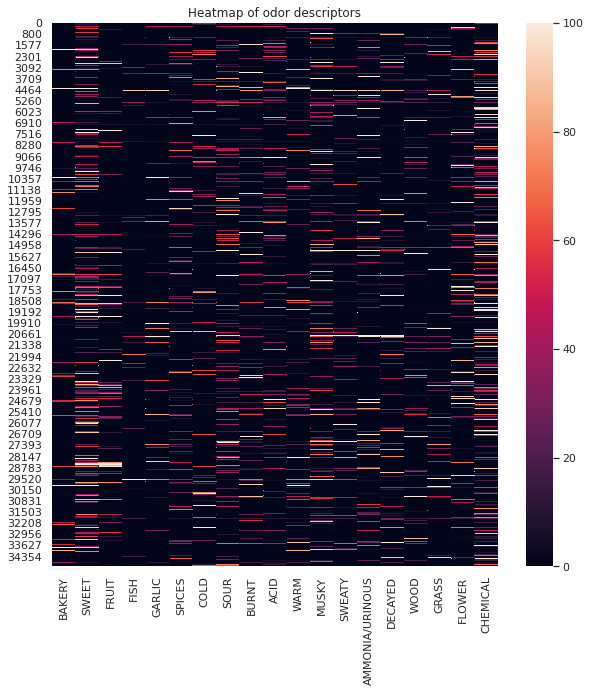

In [255]:
#display heatmap of the pivot matrix
plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=train_df.loc[:, 'BAKERY':'CHEMICAL'])
plt.title('Heatmap of odor descriptors')
plt.show()

This time, the sparsity is quite low !
In the previous section, we saw that most moelcules have been tested by most test subjects.  
However, with 19 odor descriptors per molecule, most of the values are equal to zero.  
From the metric below, we can see that 82% of all odor descriptor values are set to 0.

In [256]:
print('Number of values filled : '+str(round((train_df.loc[:, 'BAKERY':'CHEMICAL'].to_numpy() == 0).mean(), 4)*100)+"%")

Number of values filled : 82.98%


## Class consistency in labels

We do not need to check the consistency in molecular descriptors as they are generated by a library based on hard-science : each molecule gets assigned a unique row of definitve properties retrieved from peer-reviewed and reproducible protocols.  

On the label side, the odor space is defined by tests subjects rating molecules. Several molecules are tested by the same test subject, and several test subjects rate the same molecule. As smell is subjective and value ratings are not neither absolute, nor scientific units, but rather a subjective number of points.  

To know if the Odor properties are consistent amongsts subjects, we look at the variation in ratings for a single molecule amongst the test subjects :

In [257]:
#select the top 2 most rated molecules
train_df['Compound Identifier'].value_counts()[:2]

5280450    192
62902      188
Name: Compound Identifier, dtype: int64

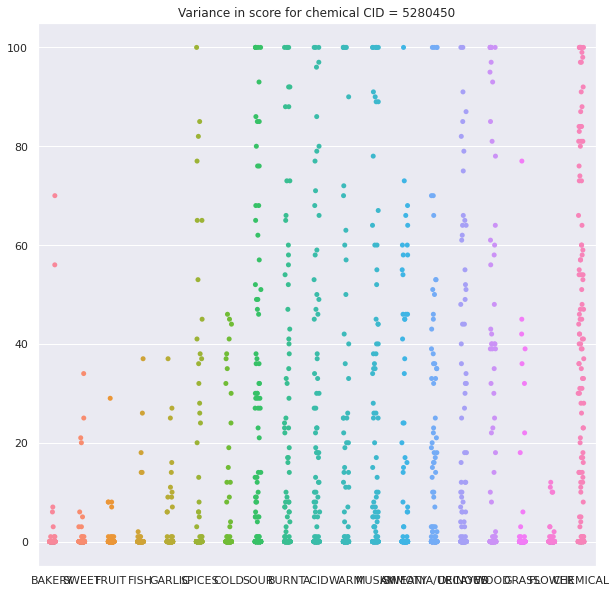

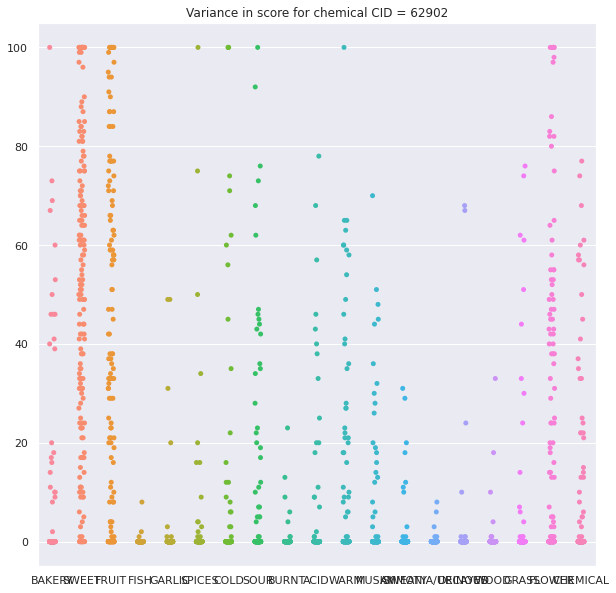

In [258]:
#and plot all subjet ratings of these two molecules
def stripplot_for_molecule(train_df, cid):

  plt.figure(figsize=(10, 10))
  ax = sns.stripplot(data=train_df[train_df['Compound Identifier'] == cid].loc[:, 'BAKERY':'CHEMICAL'])
  plt.title('Variance in score for chemical CID = '+str(cid))
  plt.show()

stripplot_for_molecule(train_df, 5280450)
stripplot_for_molecule(train_df, 62902)

We can see that there is a huge disparity in subject odor ratings. Most of the ratings are at 0, meaning that most of the subjects rated some descriptors (like Fruit, or Sour) and left the other values at 0.  
We observe a sweetness value that goes from 0 to 100 for chemical CID=62902, each subject has a different perception of the "Sweet" descriptor and will provide no useful information to the data scientist reviewing the data.  

We can say that the chemical 62902 is sweet, but not that it is very sweet, lightly sweet, nor can we say that some others detect sweetness : the values are perfectly distributed along the axis.

## Odor space visualisation

As the subjects have all subjective appreciations of the molecule odors, we want to know whether they, at least, agree on different molecules.  
Two users can have a different appreciation of the level of sweetness of a given molecule, but will one user consistently rate all molecules at a higher level of sweetness than other user ? Could we offset some user ratings to normalize the relative odor properties from subject to subject ?  

To visualize the Odor properties as a global embedding, we will use PCA to place the molecules in a 2D space. Each molecule will be colored with the highet odor rating (added in column "max_odor").

In [259]:
def add_pca_and_labels_to_train_df(train_df, kernel_type):
  #first, we rely on sum values of all descriptors to get a unique odor description of each molecule
  train_odors_df = pd.concat([train_df['Compound Identifier'], train_df.loc[:, 'BAKERY':'CHEMICAL']], axis=1)
  train_odors_df = train_odors_df.groupby(by=['Compound Identifier']).sum()

  #then we add a label to each row to identify the highest scoring odor
  train_odors_df['max_odor'] = train_odors_df.apply(lambda row: row['BAKERY':].idxmax(), axis=1)

  #we use PCA to squeeze all odor descriptors into 2 dimensions
  from sklearn.decomposition import KernelPCA
  principalComponents = KernelPCA(n_components=2, kernel=kernel_type).fit_transform(train_odors_df.loc[:, 'BAKERY':'CHEMICAL'].to_numpy())
  principalComponents_df = pd.DataFrame(principalComponents, columns=['PC1', 'PC2'])
  train_odors_df_with_pca = pd.concat([train_odors_df.reset_index(), principalComponents_df.reset_index()], axis=1)
  return train_odors_df_with_pca

add_pca_and_labels_to_train_df(train_df, 'cosine')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


Compound Identifier  BAKERY   SWEET  ...  index       PC1       PC2
0                    126    43.0  1687.0  ...      0  0.353574  0.074350
1                    176    75.0   206.0  ...      1 -0.233559 -0.225933
2                    177   545.0  1183.0  ...      2  0.247703  0.027185
3                    196    69.0   634.0  ...      3 -0.014056 -0.153865
4                    239    79.0   896.0  ...      4  0.176915 -0.088145
..                   ...     ...     ...  ...    ...       ...       ...
333              5366244    82.0   178.0  ...    333 -0.379852  0.162659
334              5367706   118.0   312.0  ...    334 -0.143938 -0.087808
335              5368076   151.0  1029.0  ...    335  0.340882  0.009633
336              6429333   119.0   441.0  ...    336 -0.098586 -0.094895
337              6999977   656.0  1010.0  ...    337  0.176596 -0.209633

[338 rows x 24 columns]

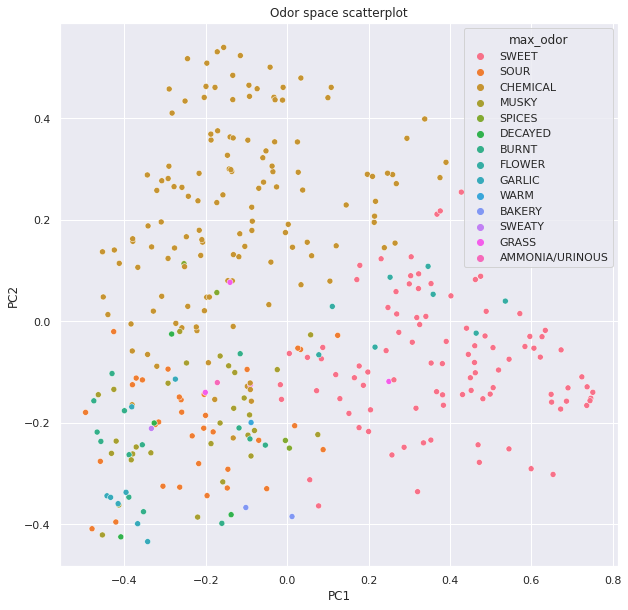

In [260]:
#and plot all subjet ratings of these two molecules
def plot_odor_space(df, kernel_type):

  pca_df = add_pca_and_labels_to_train_df(df, kernel_type)

  plt.figure(figsize=(10, 10))
  ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='max_odor')
  plt.title('Odor space scatterplot')
  plt.show()

plot_odor_space(train_df, 'cosine')

We have tried to aggregate values on mean() and sum() operators and found out that the best results come from the sum() operator. From now on, when we'll talk about mean odor ratings, the underlying operator used will be sum().  

This can be explained by the high sparsity (cf section "Odor descriptor sparsity) of the values pushing mean values close to zero.

We can make out 3 main regions :  
*   chemical/musky on the upper left
*   sweet and sour on the right
*   others on the bottom left

# Model Training : Random Forest and K-nearest-neighbor

The paper "Machine Learning for Scent: Learning Generalizable Perceptual Representations of Small Molecules" (here https://arxiv.org/pdf/1910.10685.pdf ) uses Random Forest and KNN models as a benchmark to compare the GNN solution ("QSOR Prediction Performance Benchmark" section).  

We will benchmark the Random Forest solution to predict a vector of odor descriptors thanks to the EPI Suite molecular descriptors.

Then, we will use KNN to create 19 clusters (the number of odor descriptors) to classify the molecules into odor-clusters.

## Random Forest Model

### Direct molecule descriptor to subject odor 

#### Input and Output data formatting

First, we create a test/train dataset with the molecule desciptors as values and odor descriptors as labels to predict

In [261]:
#labels to predict
rf_test_df = test_df.loc[:, 'BAKERY':'CHEMICAL']
rf_train_df = train_df.loc[:, 'BAKERY':'CHEMICAL']
rf_train_df

BAKERY  SWEET  FRUIT  FISH  ...  WOOD  GRASS  FLOWER  CHEMICAL
0         0.0    0.0    0.0   0.0  ...   0.0    0.0     0.0       0.0
1         0.0   72.0    0.0   0.0  ...   0.0    0.0     0.0       0.0
2         0.0   33.0    1.0   0.0  ...   0.0    0.0     0.0       5.0
3         0.0    9.0    2.0   0.0  ...   0.0    0.0     0.0       7.0
4         0.0   62.0    0.0   0.0  ...   0.0    0.0     0.0       0.0
...       ...    ...    ...   ...  ...   ...    ...     ...       ...
35079    56.0   50.0    0.0   0.0  ...   0.0    0.0     0.0       0.0
35080     0.0    0.0    0.0   0.0  ...   0.0    0.0     0.0       0.0
35081     0.0   58.0    7.0   0.0  ...   0.0    0.0     0.0      27.0
35082     0.0    0.0    0.0   0.0  ...   0.0    0.0     0.0       3.0
35083     0.0    0.0    0.0   0.0  ...   0.0    0.0     0.0      80.0

[25980 rows x 19 columns]

In [262]:
#create a list of molecule descriptors for every molecule CID in label df
molecule_descriptors_df

CID  Estimated Log Kow   ...  AEROWIN Junge-Pankow phi  AEROWIN Mackay phi
0         126                1.23  ...              8.850000e-04        1.960000e-03
1         176                0.09  ...              5.180000e-08        1.150000e-07
2         177               -0.17  ...              9.010000e-10        2.000000e-09
3         180               -0.24  ...              3.500000e-09        7.760000e-09
4         196                0.23  ...              1.210000e-01        2.340000e-01
..        ...                 ...  ...                       ...                 ...
471   6114390                4.69  ...              3.470000e-02        7.380000e-02
472   6429333                2.37  ...              1.830000e-05        4.060000e-05
473   6999977                0.80  ...              2.030000e-06        4.500000e-06
474  10857465                4.76  ...              7.070000e-05        1.560000e-04
475  16220109                3.93  ...              1.490000e-05        3.300000e-05

[476 rows x 52 columns]

In [263]:
#first : add molecular descriptors for each subject test molecule in the same index order
train_df_cid = pd.DataFrame(train_df.loc[:, 'Compound Identifier'])
train_df_mol = train_df_cid.merge(molecule_descriptors_df, left_on='Compound Identifier', right_on='CID')

test_df_cid = pd.DataFrame(test_df.loc[:, 'Compound Identifier'])
test_df_mol = test_df_cid.merge(molecule_descriptors_df, left_on='Compound Identifier', right_on='CID')

#second : remove "Compound Identifier" and "CID" columns from dataframes
train_df_mol.drop(['Compound Identifier', 'CID'], axis=1, inplace=True)
test_df_mol.drop(['Compound Identifier', 'CID'], axis=1, inplace=True)

We now have a dataframe with the molecular descriptors in the order of the labels dataframe : one molecular desciptor row per molecule tested in input, to be predicted against the odor descriptors in output.

We obtain the following dataframe :

In [264]:
#show test df as an example (train dataframe is structured the same way)
test_df_mol

Estimated Log Kow   ...  AEROWIN Mackay phi
0                  -0.24  ...        7.760000e-09
1                  -0.24  ...        7.760000e-09
2                  -0.24  ...        7.760000e-09
3                  -0.24  ...        7.760000e-09
4                  -0.24  ...        7.760000e-09
...                  ...  ...                 ...
3012                4.76  ...        1.560000e-04
3013                4.76  ...        1.560000e-04
3014                4.76  ...        1.560000e-04
3015                4.76  ...        1.560000e-04
3016                4.76  ...        1.560000e-04

[3017 rows x 51 columns]

#### Model selection and training

In [265]:
#import the forest
from sklearn.ensemble import RandomForestClassifier

#configure model
clf = RandomForestClassifier(random_state=0)

#fit the model based on our input/output section work
clf.fit(train_df_mol, rf_train_df)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### Model performance and result analysis

When we try the training dataset, we should get a perfect result or at least great accuracy) but instead, the model only predicts 187 values, all inthe "SWEET" column, set to 100%.

In [266]:
forest_preds = clf.predict(train_df_mol)
result_df = pd.DataFrame(forest_preds, columns=rf_train_df.columns)
result_df.value_counts()

BAKERY  SWEET  FRUIT  FISH  GARLIC  SPICES  COLD  SOUR  BURNT  ACID  WARM  MUSKY  SWEATY  AMMONIA/URINOUS  DECAYED  WOOD  GRASS  FLOWER  CHEMICAL
0.0     0.0    0.0    0.0   0.0     0.0     0.0   0.0   0.0    0.0   0.0   0.0    0.0     0.0              0.0      0.0   0.0    0.0     0.0         25793
        100.0  0.0    0.0   0.0     0.0     0.0   0.0   0.0    0.0   0.0   0.0    0.0     0.0              0.0      0.0   0.0    0.0     0.0           187
dtype: int64

When we try the test dataset (predict values that the model hasn't seen), we get 0 predictions : all molecules score 0 on all odor descriptors.

In [267]:
forest_preds = clf.predict(test_df_mol)
result_df = pd.DataFrame(forest_preds, columns=rf_train_df.columns)
result_df.value_counts()

BAKERY  SWEET  FRUIT  FISH  GARLIC  SPICES  COLD  SOUR  BURNT  ACID  WARM  MUSKY  SWEATY  AMMONIA/URINOUS  DECAYED  WOOD  GRASS  FLOWER  CHEMICAL
0.0     0.0    0.0    0.0   0.0     0.0     0.0   0.0   0.0    0.0   0.0   0.0    0.0     0.0              0.0      0.0   0.0    0.0     0.0         3017
dtype: int64

This is a very bad result and can be explained by the odor descriptor high sparsity (82% of all values set to 0).  
To correct this, we can try to predict the mean odor profile by collapsing all subject odor ratings into one per molecule with the sum of all odor ratings for each descriptor :

### Subject odor rating sum values

We will create new datasets to try to predict the mean odor descriptors. This model will output the prediction corresponding to the taste of an average subject (who doesn't exist).  
We hope that the result is meaningful. The aim of this test is to reduce sparisty and make correlations between molecular descriptors and odor properties easier to grasp by the random forest.

#### Input and output data formatting

In [268]:
#merge test and train rows by sum of all odor descriptors
train_odors_df = pd.concat([train_df['Compound Identifier'], train_df.loc[:, 'BAKERY':'CHEMICAL']], axis=1)
train_odors_df = train_odors_df.groupby(by=['Compound Identifier'], as_index=False).sum()

test_odors_df = pd.concat([test_df['Compound Identifier'], test_df.loc[:, 'BAKERY':'CHEMICAL']], axis=1)
test_odors_df = test_odors_df.groupby(by=['Compound Identifier'], as_index=False).sum()

#join CIDs with molecular descriptors
train_df_cid = pd.DataFrame(train_odors_df.loc[:, 'Compound Identifier'])
train_df_mol = train_df_cid.merge(molecule_descriptors_df, left_on='Compound Identifier', right_on='CID')

test_df_cid = pd.DataFrame(test_odors_df.loc[:, 'Compound Identifier'])
test_df_mol = test_df_cid.merge(molecule_descriptors_df, left_on='Compound Identifier', right_on='CID')

#backup the true labels for evaluation

train_odors_labels = train_odors_df['Compound Identifier']
test_odors_labels = test_odors_df['Compound Identifier']

#second : remove "Compound Identifier" and "CID" columns from dataframes
train_df_mol.drop(['Compound Identifier', 'CID'], axis=1, inplace=True)
test_df_mol.drop(['Compound Identifier', 'CID'], axis=1, inplace=True)
train_odors_df.drop(['Compound Identifier'], axis=1, inplace=True)
test_odors_df.drop(['Compound Identifier'], axis=1, inplace=True)

#### Model selection and training

We choose not to normalize the input data because the dataset would contain "float" type values, which would transform it into a multi-output-regression type.

In [269]:
#configure model
clf = RandomForestClassifier(random_state=0)

#fit the model based on our input/output section work
clf.fit(train_df_mol, train_odors_df)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

We can see from the results below that the output is not equal to zero when the input is equal to the training data which suggests that we might have solved our sparisity target labels problem.

In [270]:
forest_preds = clf.predict(train_df_mol)
result_df = pd.DataFrame(forest_preds, columns=train_odors_df.columns)
result_df

BAKERY   SWEET  FRUIT  FISH  ...   WOOD  GRASS  FLOWER  CHEMICAL
0      43.0  1687.0  564.0  13.0  ...   66.0  123.0   599.0    1149.0
1      75.0   206.0   44.0  76.0  ...  118.0  133.0   198.0     319.0
2     545.0  1183.0  175.0  42.0  ...   43.0  190.0   229.0     930.0
3      69.0   634.0   42.0  23.0  ...   55.0  128.0   308.0     482.0
4      79.0   896.0  255.0  86.0  ...  281.0  382.0   588.0     654.0
..      ...     ...    ...   ...  ...    ...    ...     ...       ...
333    82.0   178.0   14.0   9.0  ...  314.0  200.0   184.0    1533.0
334   118.0   312.0   45.0  77.0  ...  343.0  452.0   183.0     456.0
335   151.0  1029.0  824.0  23.0  ...  115.0  268.0   419.0     748.0
336   119.0   441.0   37.0  43.0  ...  101.0  159.0   362.0     570.0
337   656.0  1010.0  429.0  11.0  ...  297.0  150.0   245.0     693.0

[338 rows x 19 columns]

We now try to predict values from the test part of the dataset :

In [271]:
forest_preds = clf.predict(test_df_mol)
result_df = pd.DataFrame(forest_preds, columns=test_odors_df.columns)
result_df

BAKERY   SWEET  FRUIT   FISH  ...   WOOD  GRASS  FLOWER  CHEMICAL
0    209.0   146.0  112.0   68.0  ...  356.0  391.0    84.0    1814.0
1     75.0   206.0   44.0   76.0  ...  118.0  133.0   198.0     319.0
2    142.0   369.0  134.0   99.0  ...  317.0  225.0   340.0     912.0
3    708.0  2364.0  539.0   76.0  ...   80.0  283.0  1763.0    1171.0
4     40.0   293.0  103.0  131.0  ...  277.0  339.0   366.0     561.0
..     ...     ...    ...    ...  ...    ...    ...     ...       ...
64   269.0   464.0  119.0   87.0  ...  537.0  357.0   424.0    1052.0
65   269.0   464.0  119.0   87.0  ...  537.0  357.0   424.0    1052.0
66   504.0  1010.0  429.0   11.0  ...  297.0  150.0   245.0     693.0
67   118.0   312.0   45.0   65.0  ...  124.0  251.0   183.0     456.0
68    90.0  1966.0  245.0   64.0  ...  281.0  325.0  2229.0     858.0

[69 rows x 19 columns]

#### Model performance and result analysis

In [272]:
labelled_results_df = pd.concat([test_odors_labels, result_df], axis=1)
labelled_results_df[labelled_results_df['Compound Identifier'] == 180]

Compound Identifier  BAKERY  SWEET  FRUIT  ...   WOOD  GRASS  FLOWER  CHEMICAL
0                  180   209.0  146.0  112.0  ...  356.0  391.0    84.0    1814.0

[1 rows x 20 columns]

In [273]:
#lets rebuild test_odors_df and check its value at CID=180
test_odors_df = pd.concat([test_df['Compound Identifier'], test_df.loc[:, 'BAKERY':'CHEMICAL']], axis=1)
test_odors_df = test_odors_df.groupby(by=['Compound Identifier'], as_index=False).sum()
test_odors_df[test_odors_df['Compound Identifier'] == 180]

Compound Identifier  BAKERY  SWEET  FRUIT  ...   WOOD  GRASS  FLOWER  CHEMICAL
0                  180   108.0  497.0  207.0  ...  276.0  211.0   404.0     336.0

[1 rows x 20 columns]

We plot the odor space of the test dataset compared to the predicted dataset : we cannot see any similarities to the naked eye :

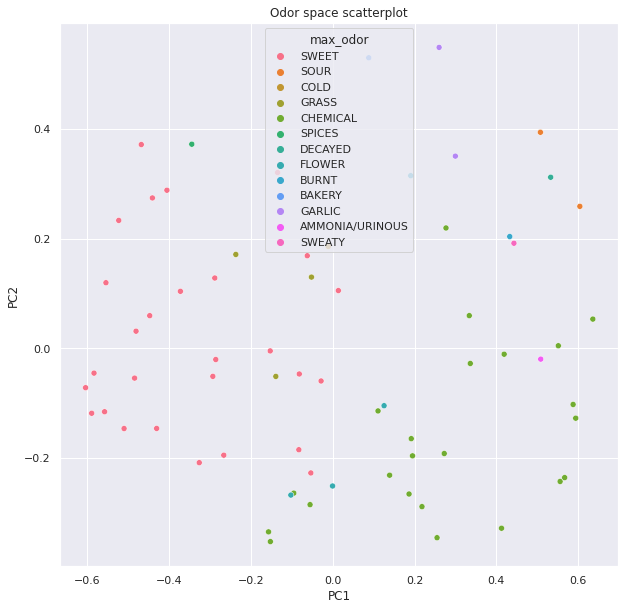

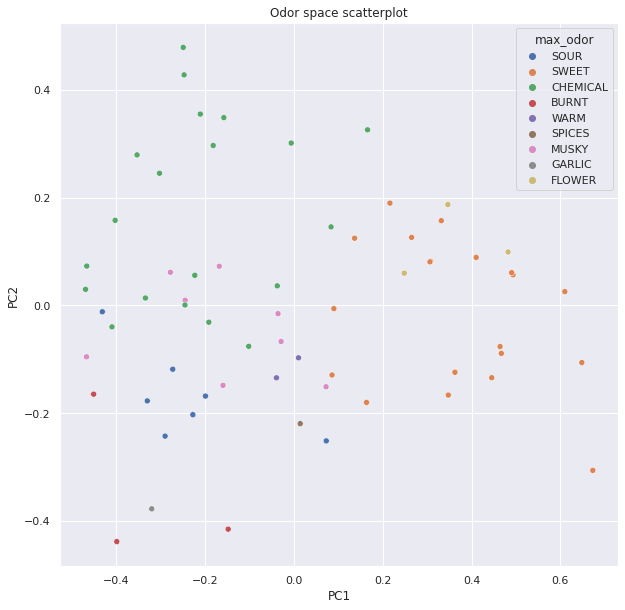

In [274]:
plot_odor_space(test_odors_df, 'cosine')
plot_odor_space(labelled_results_df, 'cosine')

For a given molecule (CID = 180), we look at the agregated values of the odor descriptors and find no similarities either :

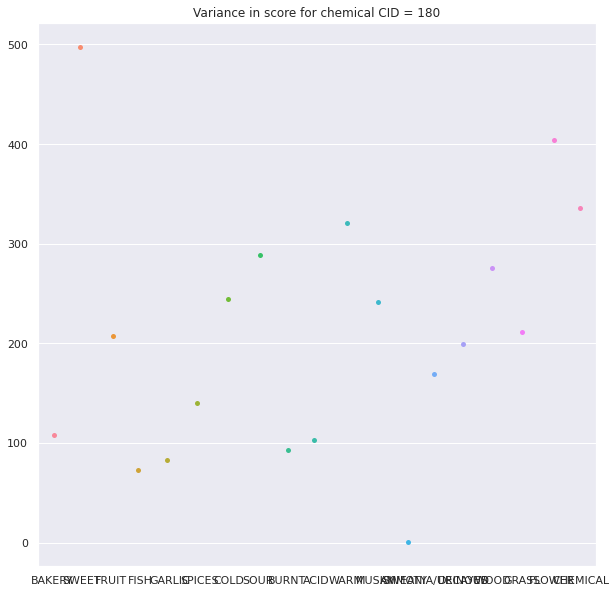

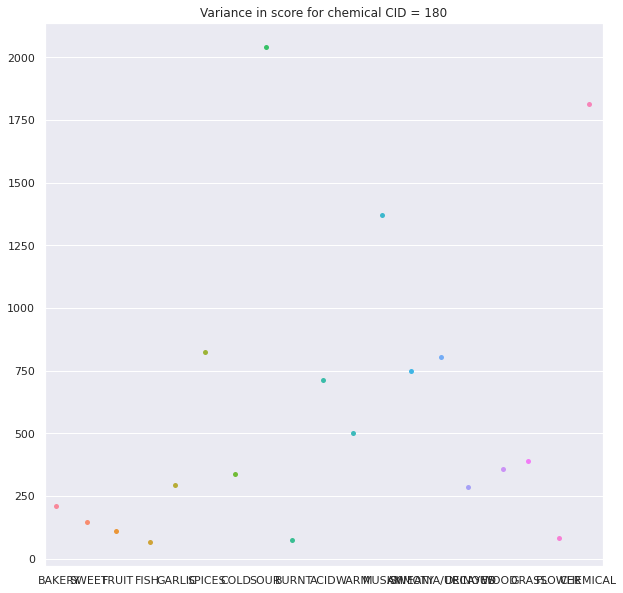

In [275]:
stripplot_for_molecule(test_odors_df, 180)
stripplot_for_molecule(labelled_results_df, 180)

Given that we cannot observe any simlarities, we look for correlations :

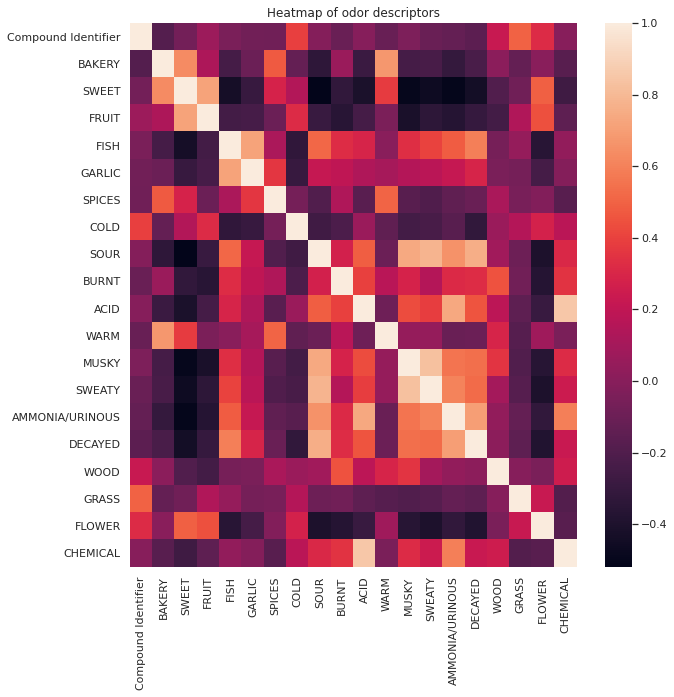

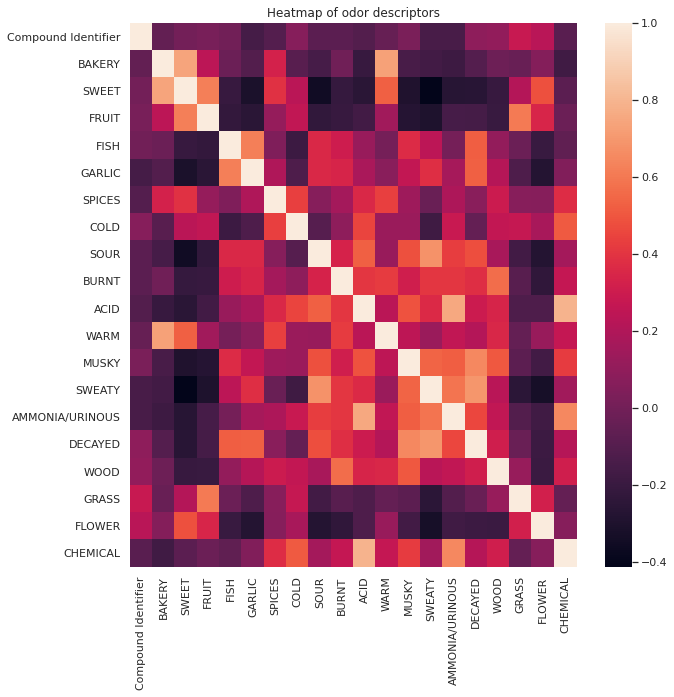

In [276]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=test_odors_df.corr())
plt.title('Heatmap of odor descriptors')
plt.show()

plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=labelled_results_df.corr())
plt.title('Heatmap of odor descriptors')
plt.show()

From the two heatmaps above, we can see that the correlations between odor descriptors are the same inside a given dataset : "CHEMICAL" and "ACID" are correlated in the two datasets (the test dataset and the predicted dataset), "SOUR" and "SWEATY" are also correlated, etc.  

We then look at the correlations between the two datasets (predicted and real) and find no correlation, which means that the raw outputted values have nothing in common :

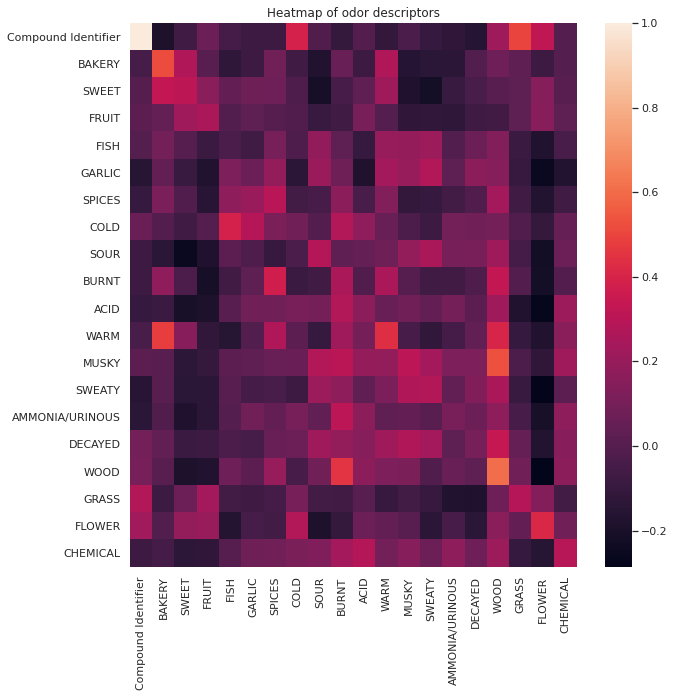

In [277]:
def corr(df1, df2):
    n = len(df1)
    v1, v2 = df1.values, df2.values
    sums = np.multiply.outer(v2.sum(0), v1.sum(0))
    stds = np.multiply.outer(v2.std(0), v1.std(0))
    return pd.DataFrame((v2.T.dot(v1) - sums / n) / stds / n,
                        df2.columns, df1.columns)

plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=corr(test_odors_df, labelled_results_df))
plt.title('Heatmap of odor descriptors')
plt.show()

To visualize the correlation between the two correlation heatmaps as seen previously, we need to display the heatmap of the two matrix correlations :

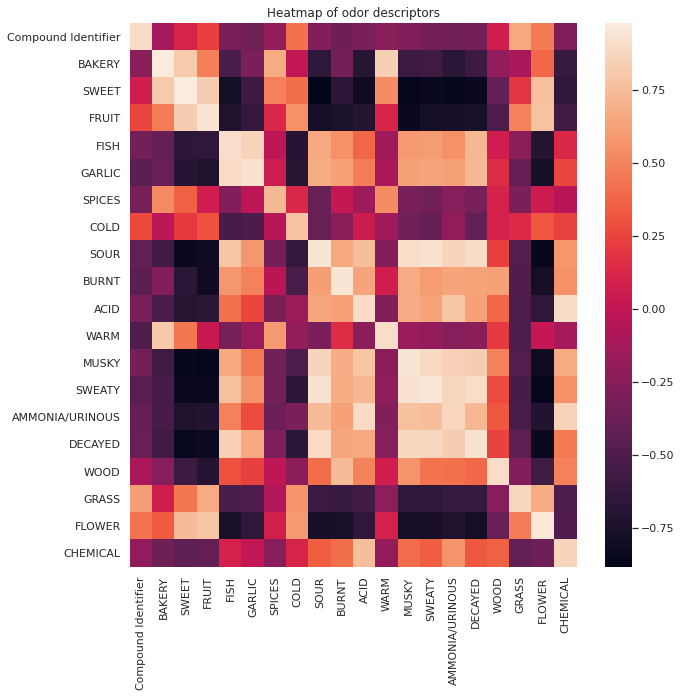

In [278]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=corr(test_odors_df.corr(), labelled_results_df.corr()))
plt.title('Heatmap of odor descriptors')
plt.show()

The heatmap above tells us that the RandomForest model can predict most values as the diagonal is highly correlated.

## K-Nearest Neighbors

This method was also recommended by the paper. We will test it in the same way as the Random Forest Classifier.

### Raw values

#### Input and Output data formatting

In [279]:
#labels to predict
rf_test_df = test_df.loc[:, 'BAKERY':'CHEMICAL']
rf_train_df = train_df.loc[:, 'BAKERY':'CHEMICAL']

#first : add molecular descriptors for each subject test molecule in the same index order
train_df_cid = pd.DataFrame(train_df.loc[:, 'Compound Identifier'])
train_df_mol = train_df_cid.merge(molecule_descriptors_df, left_on='Compound Identifier', right_on='CID')

test_df_cid = pd.DataFrame(test_df.loc[:, 'Compound Identifier'])
test_df_mol = test_df_cid.merge(molecule_descriptors_df, left_on='Compound Identifier', right_on='CID')

#second : remove "Compound Identifier" and "CID" columns from dataframes
train_df_mol.drop(['Compound Identifier', 'CID'], axis=1, inplace=True)
test_df_mol.drop(['Compound Identifier', 'CID'], axis=1, inplace=True)

#### Model Selection and training

In [280]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_df_mol, rf_train_df)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

#### Model performance and result analysis

In [281]:
knn_preds = neigh.predict(train_df_mol)
result_df = pd.DataFrame(knn_preds, columns=rf_train_df.columns)
result_df.value_counts()

BAKERY  SWEET  FRUIT  FISH  GARLIC  SPICES  COLD  SOUR  BURNT  ACID  WARM  MUSKY  SWEATY  AMMONIA/URINOUS  DECAYED  WOOD  GRASS  FLOWER  CHEMICAL
0.0     0.0    0.0    0.0   0.0     0.0     0.0   0.0   0.0    0.0   0.0   0.0    0.0     0.0              0.0      0.0   0.0    0.0     0.0         20135
                                                                                                                                         9.0           227
        34.0   0.0    0.0   0.0     0.0     0.0   0.0   0.0    0.0   0.0   0.0    0.0     0.0              0.0      0.0   0.0    0.0     0.0           188
        0.0    0.0    0.0   74.0    0.0     0.0   0.0   0.0    0.0   0.0   0.0    0.0     0.0              0.0      0.0   0.0    0.0     0.0           185
        33.0   0.0    0.0   0.0     0.0     0.0   0.0   0.0    0.0   0.0   0.0    0.0     0.0              0.0      0.0   0.0    0.0     45.0          152
                                                                               

Yet again, we see mostly values equal to zero, which means that KNN is also affected by a high sparsity. We will not try the test dataset and directly skip to the aggregated datasets.

### Aggregated values

#### Input and output data formatting

Copy paste of the data preparation

In [282]:
#merge test and train rows by sum of all odor descriptors
train_odors_df = pd.concat([train_df['Compound Identifier'], train_df.loc[:, 'BAKERY':'CHEMICAL']], axis=1)
train_odors_df = train_odors_df.groupby(by=['Compound Identifier'], as_index=False).sum()

test_odors_df = pd.concat([test_df['Compound Identifier'], test_df.loc[:, 'BAKERY':'CHEMICAL']], axis=1)
test_odors_df = test_odors_df.groupby(by=['Compound Identifier'], as_index=False).sum()

#join CIDs with molecular descriptors
train_df_cid = pd.DataFrame(train_odors_df.loc[:, 'Compound Identifier'])
train_df_mol = train_df_cid.merge(molecule_descriptors_df, left_on='Compound Identifier', right_on='CID')

test_df_cid = pd.DataFrame(test_odors_df.loc[:, 'Compound Identifier'])
test_df_mol = test_df_cid.merge(molecule_descriptors_df, left_on='Compound Identifier', right_on='CID')

#backup the true labels for evaluation

train_odors_labels = train_odors_df['Compound Identifier']
test_odors_labels = test_odors_df['Compound Identifier']

#second : remove "Compound Identifier" and "CID" columns from dataframes
train_df_mol.drop(['Compound Identifier', 'CID'], axis=1, inplace=True)
test_df_mol.drop(['Compound Identifier', 'CID'], axis=1, inplace=True)
train_odors_df.drop(['Compound Identifier'], axis=1, inplace=True)
test_odors_df.drop(['Compound Identifier'], axis=1, inplace=True)

#### Model fitting

In [283]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_df_mol, train_odors_df)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

#### Results and analysis

In [284]:
knn_preds = neigh.predict(test_df_mol)
result_df = pd.DataFrame(knn_preds, columns=test_odors_df.columns)
result_df

BAKERY  SWEET  FRUIT   FISH  ...   WOOD  GRASS  FLOWER  CHEMICAL
0    142.0  202.0  134.0  186.0  ...  142.0  153.0   103.0     454.0
1     34.0  171.0   89.0   32.0  ...  118.0   87.0   168.0     202.0
2    140.0  325.0   24.0   31.0  ...   64.0  184.0   196.0     288.0
3     69.0  395.0   67.0    0.0  ...  122.0  118.0   155.0     300.0
4     97.0   75.0    6.0    0.0  ...  142.0   66.0     9.0     181.0
..     ...    ...    ...    ...  ...    ...    ...     ...       ...
64   146.0  464.0  119.0   39.0  ...  324.0  173.0   424.0     701.0
65   146.0  464.0  119.0   39.0  ...  324.0  173.0   424.0     701.0
66    10.0   41.0   36.0    2.0  ...   15.0   86.0   162.0     403.0
67    61.0  525.0   25.0   15.0  ...  124.0  146.0    14.0     506.0
68    17.0  284.0   35.0    0.0  ...   86.0   26.0   198.0     265.0

[69 rows x 19 columns]

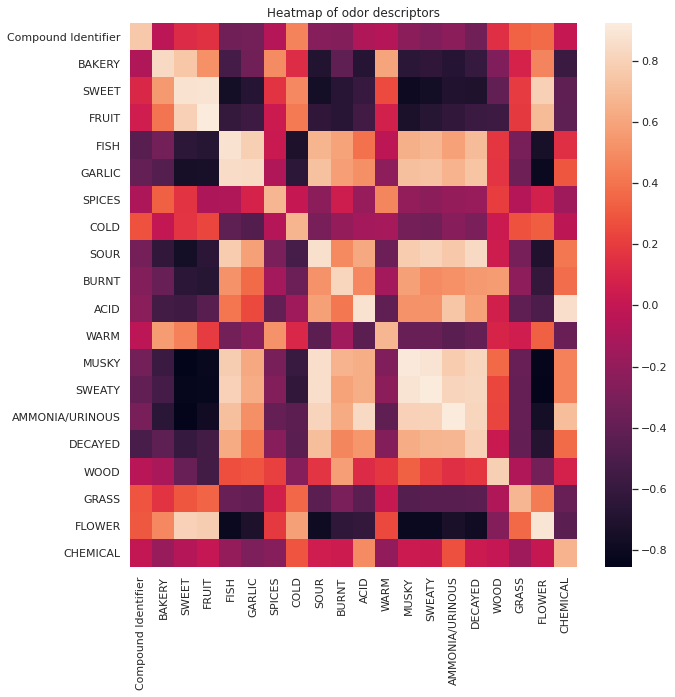

In [285]:
test_odors_df = pd.concat([test_df['Compound Identifier'], test_df.loc[:, 'BAKERY':'CHEMICAL']], axis=1)
test_odors_df = test_odors_df.groupby(by=['Compound Identifier'], as_index=False).sum()
labelled_results_df = pd.concat([test_odors_labels, result_df], axis=1)

plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=corr(test_odors_df.corr(), labelled_results_df.corr()))
plt.title('Heatmap of odor descriptors')
plt.show()

We can see a correlation between the two dataset correlations. The KNN model can make as good predictions as the Random Forest Classifier.

In [286]:
labelled_results_df

Compound Identifier  BAKERY  SWEET  FRUIT  ...   WOOD  GRASS  FLOWER  CHEMICAL
0                   180   142.0  202.0  134.0  ...  142.0  153.0   103.0     454.0
1                   262    34.0  171.0   89.0  ...  118.0   87.0   168.0     202.0
2                   264   140.0  325.0   24.0  ...   64.0  184.0   196.0     288.0
3                   323    69.0  395.0   67.0  ...  122.0  118.0   155.0     300.0
4                   702    97.0   75.0    6.0  ...  142.0   66.0     9.0     181.0
..                  ...     ...    ...    ...  ...    ...    ...     ...       ...
64              5318599   146.0  464.0  119.0  ...  324.0  173.0   424.0     701.0
65              5352837   146.0  464.0  119.0  ...  324.0  173.0   424.0     701.0
66              5364231    10.0   41.0   36.0  ...   15.0   86.0   162.0     403.0
67              5371102    61.0  525.0   25.0  ...  124.0  146.0    14.0     506.0
68             10857465    17.0  284.0   35.0  ...   86.0   26.0   198.0     265.0

[69 rows x 20 columns]

The two heatmaps below attempt to find the similarities between predicted and true values. Both dataframes (true dataframe and predicted dataframe) get normalized and substrated. The closer the value is to zero, the best it is predicted.

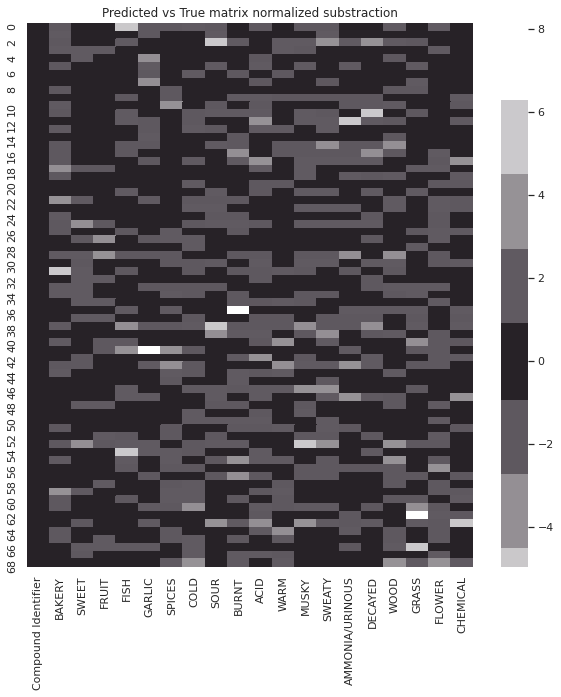

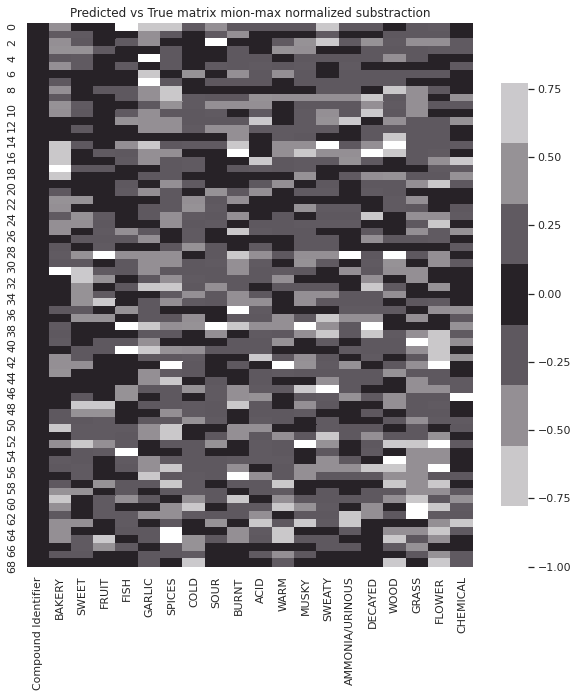

Compound Identifier    BAKERY     SWEET  ...     GRASS    FLOWER  CHEMICAL
0                   0.0 -1.242768  0.429621  ... -0.191774  1.210237 -0.414814
1                   0.0  1.615473  0.814115  ...  0.134233 -0.380856 -0.092000
2                   0.0 -1.468804 -0.726683  ... -1.145790 -0.871666  0.883837
3                   0.0  2.574441  1.453312  ... -0.108607  1.376984  0.646804
4                   0.0 -0.292434  1.139643  ...  0.513091  0.502745 -0.036592
..                  ...       ...       ...  ...       ...       ...       ...
64                  0.0 -1.136526 -0.170287  ... -0.280026 -1.887599  0.767708
65                  0.0 -1.431590  0.527257  ...  0.324629 -1.249119 -0.832276
66                  0.0  0.733718  0.930798  ...  4.572837  0.900837 -0.108902
67                  0.0 -0.328522 -1.207911  ...  0.066095  2.622636  0.215760
68                  0.0  0.362034  0.262345  ...  1.842513  2.909499  1.259488

[69 rows x 20 columns]

In [287]:
def normalize_df_min_max(df):
  return (df-df.min())/(df.max()-df.min())

def normalize_df(df):
  return (df-df.mean())/df.std()


normalized_substration = normalize_df(test_odors_df) - normalize_df(labelled_results_df)

normalize_df_min_max_substraction = normalize_df_min_max(test_odors_df) - normalize_df_min_max(labelled_results_df)


plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=normalized_substration, cmap=sns.diverging_palette(0, 0, s=0, l=500, n=9, center="dark"), center=0)
plt.title('Predicted vs True matrix normalized substraction')
plt.show()

plt.figure(figsize=(10, 10))
ax = sns.heatmap(data=normalize_df_min_max_substraction, cmap=sns.diverging_palette(0, 0, s=0, l=500, n=9, center="dark"), center=0)
plt.title('Predicted vs True matrix mion-max normalized substraction')
plt.show()


normalized_substration

We can see that the normalisation method influences our understanding of the prediction quality. In the min-max setting, the model make predictions that are quite far from the true values. In default normalization (using standard deviation), we get closer results.  
We can compute an accuraccy score by counter the values close to zero with a "closeness" parameter :

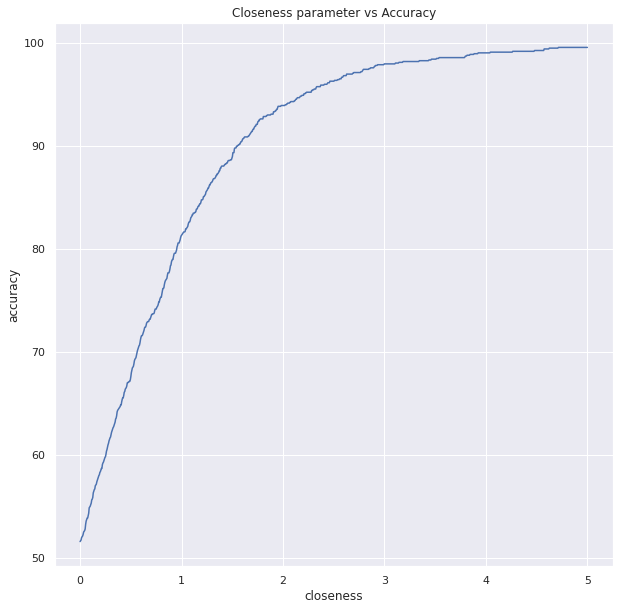

In [288]:
closeness_values_to_try = np.linspace(0,5,1000)
accuracy_by_closeness_list = []
for cpt in range(0, len(closeness_values_to_try)):
  accuracy_by_closeness_list.append([closeness_values_to_try[cpt], round((normalized_substration.loc[:, 'BAKERY':'CHEMICAL'].to_numpy() < (0 + closeness_values_to_try[cpt])).mean(), 4)*100])

accuracy_by_closeness_df = pd.DataFrame(accuracy_by_closeness_list, columns=['closeness', 'accuracy'])

plt.figure(figsize=(10, 10))
ax = sns.lineplot(data=accuracy_by_closeness_df, x='closeness', y='accuracy')
plt.title('Closeness parameter vs Accuracy')
plt.show()

From the above graph of accuracy by closeness, we can see that only 52 percent of the values are exactly predicted (no difference between the dataframes). When we increase closeness derivation, we increase accuracy (but get more approximate predictions). The maximum closeness value we could set is 5, as it is the maximum value we get in the dataframe. This would mean that any value predicted is correct, which is not true.  
A closeness parameter under one is better to predict realistic values of odor descriptors. We can see that our model gives an elbow at around 1.75 closeness, wich is not good. We have to increase the closeness parameter by a lot to get 90% accuracy.  

## GNN

To use GNN, we first have to convert our dataset of molecular descriptor to graphs.  

### Convert Molecules to Graphs

We import two packages :  
*   pysmiles to convert the SMILES representation of a molecule to a graph
*   RDkit to visalize a molecule and compare it to the graph from pysmiles so we can check for representation accuracy

#### Library testing

In [289]:
!pip install pysmiles

[(0, 'C'), (1, 'C'), (2, 'C'), (3, 'C'), (4, 'C'), (5, 'C'), (6, 'C'), (7, 'C'), (8, 'C'), (9, 'C'), (10, 'C'), (11, 'C')]
[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2)]


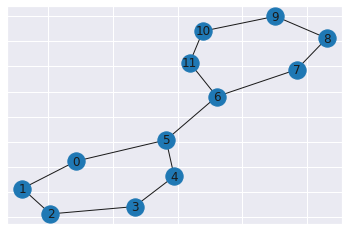

In [290]:
from pysmiles import read_smiles
import networkx as nx

smiles = 'C1CC[13CH2]CC1C1CCCCC1' #example smile
mol = read_smiles(smiles)

# atom vector (C only)
print(mol.nodes(data='element'))
print(mol.nodes(data='hcount'))
# adjacency matrix
# print(nx.read)

nx.draw_networkx(mol)


We output the links between atoms, then the hydrogen bonds to prove that the graph object contains all the needed information.  
Then we draw the graph to get a representation of the nodes and their links.

In [291]:
!!pip install kora -q
import kora.install.rdkit

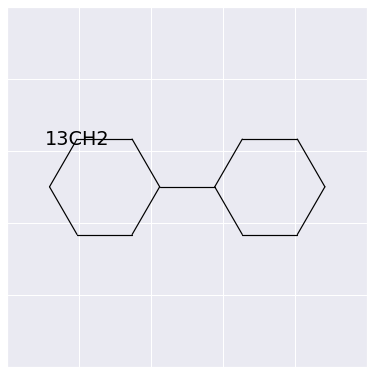

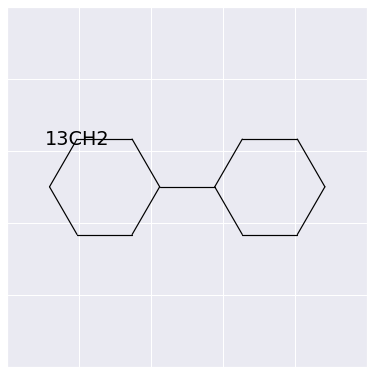

In [292]:
from rdkit import Chem
from rdkit.Chem import Draw

import matplotlib.pyplot as plt
%matplotlib inline

penicillin_g = Chem.MolFromSmiles(smiles)

Draw.MolToMPL(penicillin_g, size=(200, 200))

We use RDkits to draw the same smile molecule from SMILES and see that the molecule representation is the same as the graph representation.

From the two tests above, we can see that the representation of the test SMILE string gives two hexagons linked by a bond, therefore the graph representation of a given molecule is consistent and we can use the pysmiles library to generate graphs from the SMILE information.

#### Apply to all molecules

Reading a SMILE string gives a graph object :

In [302]:
(read_smiles('OC1=CC=C(C=O)C=C1'))

We store graph objects in each row :

In [304]:
molecule_smiles_df['smile_graph'] = molecule_smiles_df.apply(lambda row: read_smiles(row['SMILES']), axis=1)
molecule_smiles_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


CID  ...                                        smile_graph
0         126  ...                        (0, 1, 2, 3, 4, 5, 6, 7, 8)
1         176  ...                                       (0, 1, 2, 3)
2         177  ...                                          (0, 1, 2)
3         180  ...                                       (0, 1, 2, 3)
4         196  ...                     (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
..        ...  ...                                                ...
471   6114390  ...  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
472   6429333  ...                 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
473   6999977  ...                     (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
474  10857465  ...  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
475  16220109  ...         (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)

[476 rows x 3 columns]

From this point, we should apply vectorisation of these graphs and message passing with a framework like Tensorflow or PyTorch.

# Conclusion

The dataset is complex : multiple molecules are tested by multiple test subjects. These test subjects all rate the molecules along 19 odor descriptors, and give them wildly different scores. From this dataset, we can say that taste seems to be subjective : no two participant can neither agree on the perceived smell of a molecule, nor rate their perceived level of odor. Sweet molecules are rating at all levels from 0 to 100, some molecules have a definite "fishy" odor but again, all score range from 0 to 100.  
Adding concrete molecular descriptors computed with the EPI Suite gives this project a more scientific approache and gives the models a chance to predict some correlation from hard scientific measures.  
In the first part, we cleaned the dataset by removing unknown values from rows and columns of the participant dataset and molecular descriptors dataset.  
In the second part, we evaluated the distribution of odor ratings on single molecules by displaying a scatterplot of perceived odors, and on multiple molecules by using PCA to plot the odor space of all molecules. We also analysed the repartition of test subject to molecule rating and found that the dataset was 90% complete in this aspect.  
In the last part we compared the use of RandomForests and KNN models to predict odors and found no difference. Both models struggle because of the data structure and weak label correlations. We fixed the weak labelling by applying a sum operator and both models performed better, but we also lost the ability to strongly predict odor ratings, leaving us with high level correlations and a closeness approximation of an odor for a given molecule.  

In conclusion, odor prediction is hard because odor cannot be measured by a scientific instrument. Vision can me measured with light units (Lumens, Herts, Joules, etc.), hearing can also be measured by scientific means (Decibels, Hertz; etc.). Odor and taste do not have a universal scientific unit, are not measured with recognized components (light color in RGB space for example), and can only be detected by human test subjects. These humans have subjective senses that vary from subject to subject depending on learned experiences and cannot be used as scientific instruments but rather as witnesses. 